In [ ]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

In [6]:
import ta
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autotime

# Download historical price data for a stock
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.59 ms (started: 2024-11-22 11:30:28 +00:00)


In [15]:
def save_processed_data(processed_dfs='', values_list='', output_dir='processed_data'):
    """
    Save processed DataFrames list and numpy arrays list to single files
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save list of DataFrames using pickle
    with open(output_path / 'processed_dfs.pkl', 'wb') as f:
        joblib.dump(processed_dfs, f)
    
    # Save numpy arrays
    with open(output_path / 'values_array.pkl', 'wb') as f:
        joblib.dump(values_list, f)

def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    with open(data_path / 'values_array.pkl', 'rb') as f:
        values_list = joblib.load(f)
    
    return processed_dfs, values_list

# Save both lists
# save_processed_data(combined_dfs, combined_values, 'processed_data')

# Later load them
dfs_list, values_list = load_processed_data('processed_data')

time: 101 ms (started: 2024-11-22 12:01:38 +00:00)


In [16]:
dfs_list[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,Lower Band,Ulcer Index,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-16,11.462602,13.588571,13.691786,13.430714,13.625714,1000000.0,53.720202,-40.920847,-0.007642,0.082958,...,12.850948,6.368184,564.736488,1.784183,50.608489,10.548855,-3.418024,12.356305,16.000357,13.587143
2011-08-17,11.461395,13.587143,13.732857,13.500000,13.653929,1000000.0,53.696962,-41.006850,-0.000105,-0.113662,...,12.839185,6.416486,497.700387,1.823144,50.372918,10.291735,-3.410067,12.751208,15.711276,13.073214
2011-08-18,11.027872,13.073214,13.308929,12.906071,13.244286,1000000.0,45.984883,-71.966454,-0.037825,0.926057,...,12.761759,6.686873,645.802434,1.591148,50.137814,10.037805,-3.396865,13.168186,15.424764,12.715357
2011-08-19,10.726002,12.715357,13.107143,12.714286,12.934643,1000000.0,41.513874,-93.293223,-0.027373,-0.088729,...,12.624472,7.120951,707.291371,1.742971,49.903177,9.787063,-3.378466,13.593889,15.140825,12.730000
2011-08-22,10.738357,12.730000,13.031429,12.681786,13.018214,1000000.0,41.763382,-91.561812,0.001152,-0.310062,...,12.525591,7.472308,569.391019,1.997446,49.669010,9.539509,-3.354922,14.014846,14.859461,13.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,1000000.0,53.621399,-42.696626,0.003643,0.247281,...,222.507266,1.664750,30163.314500,-1.569032,104.839212,114.481354,117.032685,177.737174,113.773702,233.399994
2024-10-28,233.143494,233.399994,234.729996,232.550003,233.320007,1000000.0,56.742652,-32.306559,0.008599,-0.069975,...,222.494192,1.484857,26178.111649,-1.048381,104.562621,113.857934,116.083356,166.331105,113.216242,233.669998


time: 21.4 ms (started: 2024-11-22 12:01:38 +00:00)


Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days and Bollinger Bands')

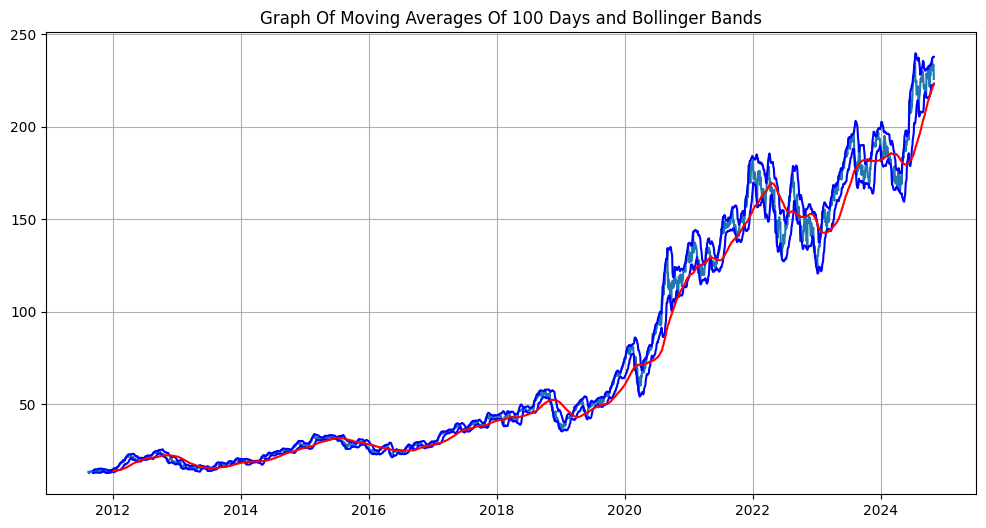

time: 380 ms (started: 2024-11-22 12:01:45 +00:00)


In [17]:
aapl_close = dfs_list[0]["Close"].squeeze() 
ma100 = aapl_close.rolling(100).mean()

BB = ta.volatility.BollingerBands(aapl_close, window=20)
high_band = BB.bollinger_hband()
low_band = BB.bollinger_lband()
    
plt.figure(figsize = (12,6))
plt.plot(aapl_close)
plt.plot(high_band, 'b')
plt.plot(low_band, 'b')
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days and Bollinger Bands')

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


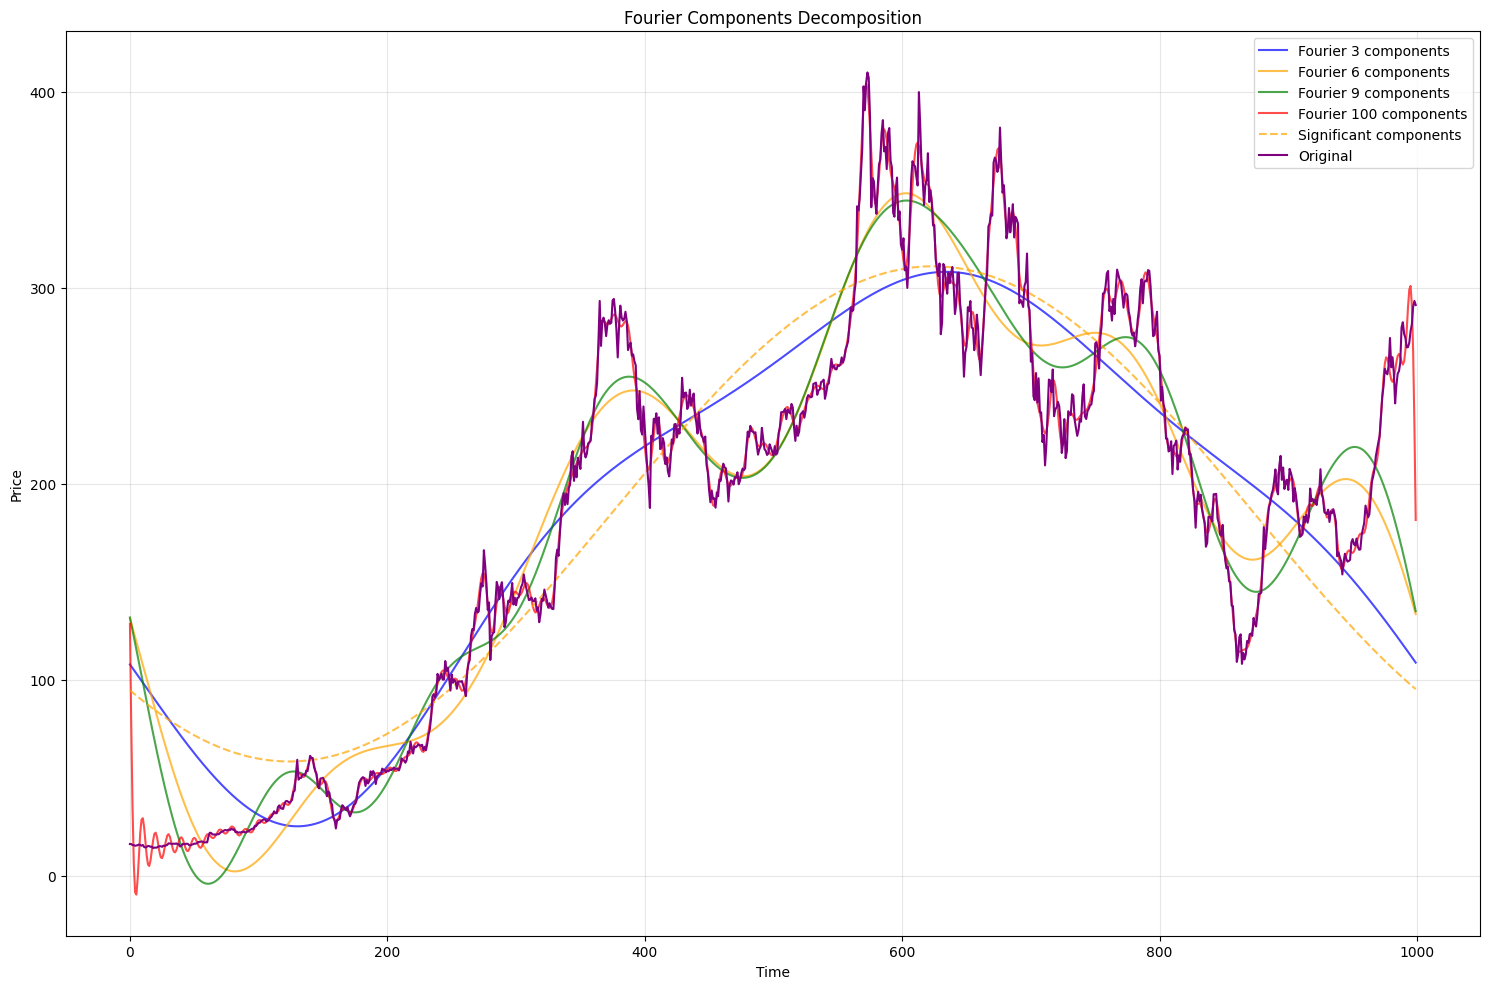

In [208]:
def plot_fourier_components(stock_data, figsize=(15, 10)):
    """
    Plot real parts of Fourier components and significant components
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock price data with Close column
        figsize (tuple): Figure size for the plot
    """
    # Get close prices
    close_prices = stock_data["Close"].squeeze()
    
    # Calculate FFT
    close_fft = np.fft.fft(np.asarray(close_prices.tolist()))
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot Fourier components
    components = [3, 6, 9, 100]
    colors = ['blue', 'orange', 'green', 'red']
    
    for num_, color in zip(components, colors):
        # Filter FFT
        fft_filtered = np.copy(close_fft)
        fft_filtered[num_:-num_] = 0
        
        # Inverse FFT and get real part
        ifft_signal = np.fft.ifft(fft_filtered)
        
        plt.plot(ifft_signal, 
                label=f'Fourier {num_} components', 
                alpha=0.7,
                color=color)
    
    # Add significant components
    magnitude_threshold = 0.1 * np.max(np.abs(close_fft))
    significant_fft = np.copy(close_fft)
    significant_fft[np.abs(significant_fft) < magnitude_threshold] = 0
    ifft_significant = np.fft.ifft(significant_fft)
    
    plt.plot(ifft_significant, 
            label='Significant components', 
            alpha=0.7,
            color='orange',
            linestyle='--')
    
    # Plot original data
    plt.plot(close_prices.values, label='Original', color='purple')
    
    plt.title('Fourier Components Decomposition')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

plot_fourier_components(processed_dfs[5][2000:3000])
plt.show()

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

series = dfs_list[0].iloc[:, 1]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      ('Close', 'AAPL')   No. Observations:                 3325
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6463.260
Date:                Fri, 22 Nov 2024   AIC                          12938.519
Time:                        12:28:32   BIC                          12975.173
Sample:                             0   HQIC                         12951.635
                               - 3325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0162      0.010     -1.694      0.090      -0.035       0.003
ar.L2         -0.0254      0.010     -2.452      0.014      -0.046      -0.005
ar.L3         -0.0264      0.011     -2.436      0.0

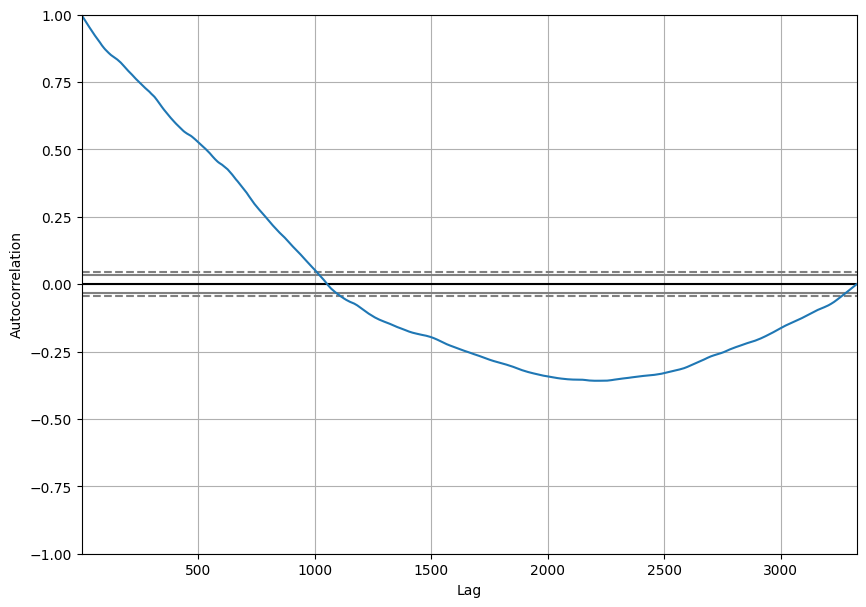

time: 183 ms (started: 2024-11-22 12:28:33 +00:00)


In [38]:
plt.figure(figsize=(10, 7), dpi=100)
autocorrelation_plot(series)
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

time: 2min 24s (started: 2024-11-22 12:28:37 +00:00)


Test MSE: 8.369


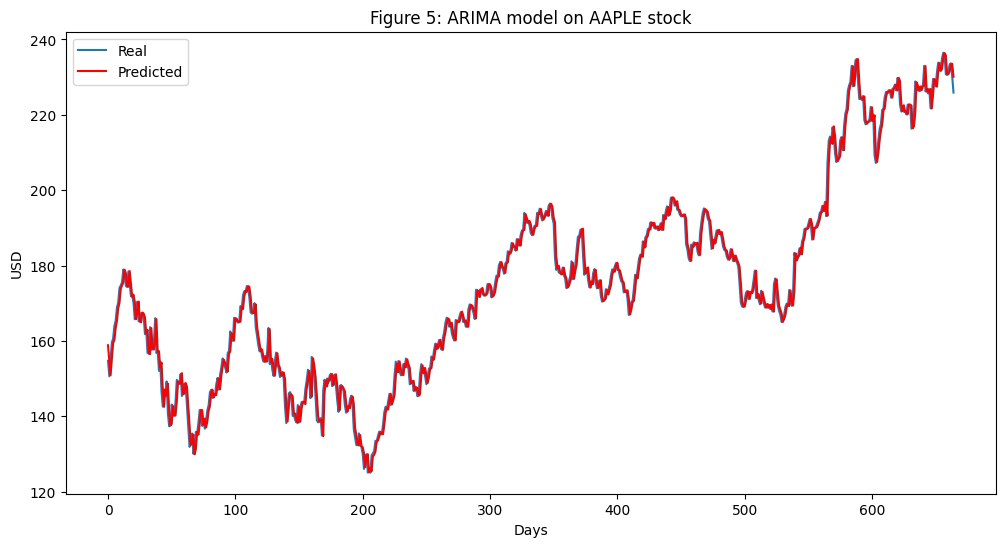

time: 216 ms (started: 2024-11-22 12:31:02 +00:00)


In [40]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on AAPLE stock')
plt.legend()
plt.show()

In [44]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan


X = dfs_list[0].drop('Close Next Day', axis=1)  # Replace 'target' with your actual target variable name
y = dfs_list[0]['Close Next Day']

# Add a constant to the model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_test_results = dict(zip(['Lagrange multiplier statistic', 'p-value', 'f-statistic', 'f p-value'], bp_test))

print(bp_test_results)

{'Lagrange multiplier statistic': 660.6320137069778, 'p-value': 1.6059342272317494e-120, 'f-statistic': 29.187344245831426, 'f p-value': 2.5519575109983e-136}
time: 305 ms (started: 2024-11-22 12:48:22 +00:00)


/tmp/ipykernel_238/709620707.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = dfs_list[0].drop('Close Next Day', axis=1)  # Replace 'target' with your actual target variable name
